<a href="https://colab.research.google.com/github/weilly0912/Colab-ML/blob/main/TensorFlow_Lite_Converter/Pytorch_to_Tensoflow_Lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pytorch Model Zoo : https://pytorch.org/serve/model_zoo.html

Pytroch torchvision model : https://pytorch.org/vision/0.8/models.html


# **(1) Pytorch(.pth) -> ONNX -> TensorFlow Lite**
*load **.pkl or **.pth*

In [ ]:
# (0) Downolad Source package
!pip install onnx
!pip install onnx-tf

In [ ]:
# (1) Pytorch From torchvision -> ONNX
import torch
import torchvision.models as models
mobilenet = models.mobilenet_v2()
torch.onnx.export(mobilenet, torch.randn(1,3,224,224), "mobilenet_v2.onnx")

# -- save and load model (pkl)
torch.save(mobilenet,"mobilenet_v2.pkl") # mobilenet_v2.pt # mobilenet_v2.pth
model = torch.load("mobilenet_v2.pkl")

# (2) ONNX -> Tensorflow
!onnx-tf convert -i mobilenet_v2.onnx -o /root/mobilenetv2

# (3) Tensorflow -> TF Lite
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_saved_model("/root/mobilenetv2")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with tf.io.gfile.GFile( "mobilenetv2.tflite" , 'wb') as f:
   f.write(tflite_model)
print("Quantization complete! - model.tflite ")

# **(2) Pytorch(DarkNet)**

In [ ]:
# 下載源碼
!git clone https://github.com/AlexeyAB/darknet.git

# 簡化路徑
!ln -fs /content/drive/MyDrive/Colab_Model_ZOO/YOLOv4_TINY_Training/darknet /app

# 修改 MakeFile
%cd /content/darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=0/' Makefile
!make

In [ ]:
# show image
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline
  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height))
  fig = plt.gcf()
  fig.set_size_inches(18,10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image,cv2.COLOR_BGR2RGB))
  plt.show()

# inference
!./darknet detect cfg/yolov4.cfg "/app/yolov4_hunglc007.weights" /content/darknet/data/dog.jpg

# show result
imShow("/content/darknet/predictions.jpg")

# **(3) Pytorch(DarkNet) -> ONNX -> TensorFlow Lite**
load cfg and weight

In [ ]:
# (0) Downolad Source Code and Package
#!git clone https://github.com/WongKinYiu/PyTorch_YOLOv4
%cd /content/
!git clone https://github.com/Tianxiaomo/pytorch-YOLOv4
!pip install onnx-tf
!ln -fs /content/drive/MyDrive/Colab_Model_ZOO/YOLOv4_TINY_Training/darknet /app

In [ ]:
%cd /content/pytorch-YOLOv4

# (1) Pytorch From torchvision -> ONNX
import torch
from tool.darknet2pytorch import Darknet
model_weight = "/app/backup_relu/my_yolov4-tiny-custom_final.weights" #@param["/app/backup_relu/yolov4-tiny_10000.weights","/app/backup_relu/my_yolov4-tiny-custom_final.weights"]
model_cfg = "/app/cfg/my_yolov4-tiny-custom.cfg" #@param["/app/cfg/my_yolov4-tiny-custom.cfg"]
model = Darknet(model_cfg)
model.print_network()
model.load_weights(model_weight)
torch.onnx.export(model, torch.randn(1,3,416,416), "/content/yolov4-tiny.onnx")

# (2) ONNX -> Tensorflow
!rm -r /content/checkpoints
!onnx-tf convert -i /content/yolov4-tiny.onnx -o /content/yolov4-tiny

# (3) Tensorflow -> TF Lite
import tensorflow as tf
import numpy as np
def representative_dataset_gen(): # 模擬數據集 (已亂隨構成的測試集會影像精準度)
    for _ in range(250):
        yield [np.random.uniform(0.0, 1.0, size=(1, 3, 416, 416)).astype(np.float32)] # H,W,C 為模組所須輸入的影像大小

converter = tf.lite.TFLiteConverter.from_saved_model("/content/yolov4-tiny")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type  = tf.uint8
converter.inference_output_type = tf.uint8
converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()
with tf.io.gfile.GFile( "/content/yolov4-tiny-quant.tflite" , 'wb') as f:
   f.write(tflite_model)
print("Quantization complete! - model.tflite ")

# **(4) Pytorch(DarkNet) -> TensorFlow -> TensorFlow Lite**
load weight



(1) [解決 cannot reshape array of size 1665179](https://stackoverflow.com/questions/62406263/) -> cannot-reshape-array-of-size-1665179-into-shape-512-512-3-3)  
若換 DataSet 則需更改 /content/tensorflow-yolov4-tflite/core/config.py 中的 __C.YOLO.CLASSES

(2) 改 common.py -> conv = tf.nn.leaky_relu(conv, alpha=0.1)

(3) [解決 Quantization not yet supported for op: 'DEQUANTIZE' for tensorflow 2.x](https://stackoverflow.com/questions/63628513/quantization-not-yet-supported-for-op-dequantize-for-tensorflow-2-x) 
 -> swich TF 1.15



**- 環境建置**

In [ ]:
# 重啟環境 解決tensorflow版本安裝衝突問題
import os
os.kill(os.getpid(), 9)

In [ ]:
!pip3 install --index-url https://google-coral.github.io/py-repo/ tflite_runtime
!pip install tensorflow==2.3.0rc0 #2.3.0rc0

Looking in indexes: https://google-coral.github.io/py-repo/
     |████████████████████████████████| 1.5 MB 4.8 MB/s 
     |████████████████████████████████| 320.4 MB 9.1 kB/s 
     |████████████████████████████████| 20.1 MB 123.9 MB/s 
     |████████████████████████████████| 3.0 MB 39.1 MB/s 
     |████████████████████████████████| 2.9 MB 45.5 MB/s 
     |████████████████████████████████| 459 kB 65.9 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully un

In [ ]:
import tensorflow
print(tensorflow.__version__) 

2.3.0-rc0


In [ ]:
# 下載源碼
%cd /content
!git clone https://github.com/hunglc007/tensorflow-yolov4-tflite
!git clone https://github.com/OmniXRI/Yolov4-tiny_Colab_User_Datasets

/content
Cloning into 'tensorflow-yolov4-tflite'...
remote: Enumerating objects: 790, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 790 (delta 1), reused 1 (delta 0), pack-reused 786
Receiving objects: 100% (790/790), 197.65 MiB | 24.68 MiB/s, done.
Resolving deltas: 100% (372/372), done.
Cloning into 'Yolov4-tiny_Colab_User_Datasets'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 35 (delta 12), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [ ]:
# 簡化路徑
!ln -fs /content/drive/MyDrive/Colab_Model_ZOO/YOLOv4_TINY_Training/darknet /app

**- [模組轉換](https://blog.csdn.net/Leo_whj/article/details/108615287)**

In [ ]:
#  Darknet 轉換為 tensorflow
%cd /content/tensorflow-yolov4-tflite
model_weight = "/app/backup_relu/my_yolov4-tiny-custom_final.weights" #@param["/app/backup_relu/yolov4-tiny_10000.weights","/app/backup_relu/my_yolov4-tiny-custom_final.weights", "/content/drive/MyDrive/Colab_Model_ZOO/yolov4.weights", "/app/backup_relu/my_yolov4-tiny-custom_1000.weights", "/app/yolov4_hunglc007.weights"]
frame_type  = "tflite" #@param["tflite","tf","trt"]
tiny = "True" #@param["True","False"]
!rm -r /content/checkpoints/yolov4-tiny
!python save_model.py --weights {model_weight} --output /content/checkpoints/yolov4-tiny --input_size 416 --model yolov4 --tiny {tiny} --framework {frame_type} 

/content/tensorflow-yolov4-tflite
rm: cannot remove '/content/checkpoints/yolov4-tiny': No such file or directory
2021-12-22 13:07:16.042383: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-12-22 13:07:18.414831: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-12-22 13:07:18.470299: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-22 13:07:18.470369: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9ac385734d14): /proc/driver/nvidia/version does not exist
2021-12-22 13:07:18.470826: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operati

In [ ]:
#  tensorflow 轉換為 tensorflow lite
%cd /content/tensorflow-yolov4-tflite
!python convert_tflite.py --weights /content/checkpoints/yolov4-tiny --output /content/checkpoints/yolov4-tiny/yolov4tiny-416.tflite
#!python convert_tflite.py --weights /content/checkpoints/yolov4-tiny --output ./checkpoints/yolov4-416-int8.tflite --quantize_mode int8 --dataset "/app/data/my_val.txt"

/content/tensorflow-yolov4-tflite
2021-12-21 19:04:36.278590: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-12-21 19:04:38.542486: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-12-21 19:04:38.555443: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-21 19:04:38.555495: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f567792b58fd): /proc/driver/nvidia/version does not exist
2021-12-21 19:04:38.555897: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the a

In [ ]:
#  tensorflow 轉換為 tensorflow lite
#%tensorflow_version 1.x
%cd /content/tensorflow-yolov4-tflite

import tensorflow as tf
import numpy as np
import os
import cv2
import core.utils as utils

def representative_data_gen():
  fimage = open("/app/data/my_val.txt").read().split()
  for input_value in range(10):
    if os.path.exists(fimage[input_value]):
      original_image=cv2.imread(fimage[input_value])
      original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
      image_data = utils.image_preprocess(np.copy(original_image), [416, 416])
      img_in = image_data[np.newaxis, ...].astype(np.float32)
      print("calibration image {}".format(fimage[input_value]))
      yield [img_in]
    else:
      continue

converter =  tf.compat.v1.lite.TFLiteConverter.from_saved_model("/content/checkpoints/yolov4-tiny")
#converter =  tf.lite.TFLiteConverter.from_saved_model("/content/checkpoints/yolov4-tiny")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [ tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.SELECT_TF_OPS ]
converter.experimental_new_converter = True
converter.allow_custom_ops = True
converter.inference_input_type  = tf.float32
converter.inference_output_type = tf.float32
converter.representative_dataset = representative_data_gen

tflite_model = converter.convert()
with tf.io.gfile.GFile( "/content/checkpoints/yolov4-tiny/yolov4tiny-416-quant.tflite" , 'wb') as f:
   f.write(tflite_model)
print("Quantization complete! - model.tflite ")

/content/tensorflow-yolov4-tflite
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from /content/checkpoints/yolov4-tiny/variables/variables
INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}
INFO:tensorflow:input tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_1
INFO:tensorflow: tensor name: serving_default_input_1:0, shape: (-1, 416, 416, 3), type: DT_FLOAT
INFO:tensorflow:output tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: tf_op_layer_concat_15
INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (1, -1, 4), type: DT_FLOAT
INFO:tensorflow:Tensor's key in saved_model's tensor_map: tf_op_layer

Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the f

calibration image /content/drive/MyDrive/Colab_Model_ZOO/YOLOv4_TINY_Training/darknet/data/my_dataset/img_081.jpg
calibration image /content/drive/MyDrive/Colab_Model_ZOO/YOLOv4_TINY_Training/darknet/data/my_dataset/img_082.jpg
calibration image /content/drive/MyDrive/Colab_Model_ZOO/YOLOv4_TINY_Training/darknet/data/my_dataset/img_083.jpg
calibration image /content/drive/MyDrive/Colab_Model_ZOO/YOLOv4_TINY_Training/darknet/data/my_dataset/img_084.jpg
calibration image /content/drive/MyDrive/Colab_Model_ZOO/YOLOv4_TINY_Training/darknet/data/my_dataset/img_085.jpg
calibration image /content/drive/MyDrive/Colab_Model_ZOO/YOLOv4_TINY_Training/darknet/data/my_dataset/img_086.jpg
calibration image /content/drive/MyDrive/Colab_Model_ZOO/YOLOv4_TINY_Training/darknet/data/my_dataset/img_087.jpg
calibration image /content/drive/MyDrive/Colab_Model_ZOO/YOLOv4_TINY_Training/darknet/data/my_dataset/img_088.jpg
calibration image /content/drive/MyDrive/Colab_Model_ZOO/YOLOv4_TINY_Training/darknet/da

**- 推理應用**

/content/tensorflow-yolov4-tflite
2021-12-21 02:52:50.093425: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-12-21 02:52:52.265555: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-12-21 02:52:52.282505: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-21 02:52:52.282570: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (78dd79a73186): /proc/driver/nvidia/version does not exist
2021-12-21 02:52:52.315607: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the a

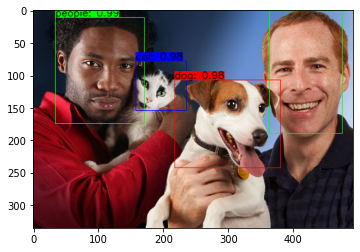

In [ ]:
# Run demo tflite model
%cd /content/tensorflow-yolov4-tflite
image = "/content/Yolov4-tiny_Colab_User_Datasets/test01.jpg" #@param["/content/tensorflow-yolov4-tflite/data/kite.jpg","/app/data/dog.jpg","/content/Yolov4-tiny_Colab_User_Datasets/test01.jpg"]
tflite = "/content/checkpoints/yolov4-tiny/yolov4tiny-416-quant.tflite" #@param["/content/checkpoints/yolov4-tiny/yolov4tiny-416.tflite","/content/checkpoints/yolov4-tiny/yolov4tiny-416-quant.tflite"]
!rm /content/tensorflow-yolov4-tflite/result.png
!python detect.py --weights {tflite} --size 416 --model yolov4 --image {image} --framework tflite 

# display
import matplotlib.pyplot as plt
import cv2
image = cv2.imread("/content/tensorflow-yolov4-tflite/result.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)


In [ ]:
# 函式設計
def filter_boxes(box_xywh, scores, score_threshold=0.4, input_shape = ([416,416])):
    scores_max = np.max(scores,axis=2)

    mask = scores_max >= score_threshold
    mask = np.squeeze(mask)

    boxs = np.squeeze(box_xywh)
    score = np.squeeze(scores)

    class_boxes = []
    pred_conf = []
    for i in (np.where(mask==True)):
      class_boxes.append(boxs[i][:])
      pred_conf.append(score[i][:])

    class_boxes = np.expand_dims(class_boxes, axis=0)
    pred_conf  = np.expand_dims(pred_conf, axis=0)

    box_xy = np.split(class_boxes, (2, 2), axis=-1)[0]
    box_wh = np.split(class_boxes, (2, 2), axis=-1)[2]

    box_yx = box_xy[..., ::-1]
    box_hw = box_wh[..., ::-1]

    box_mins = (box_yx - (box_hw / 2.)) / input_shape
    box_maxes = (box_yx + (box_hw / 2.)) / input_shape
    boxes = np.concatenate([
        box_mins[..., 0:1],  # y_min
        box_mins[..., 1:2],  # x_min
        box_maxes[..., 0:1],  # y_max
        box_maxes[..., 1:2]  # x_max
    ], axis=-1)
    # return tf.concat([boxes, pred_conf], axis=-1)
    return (boxes, pred_conf)

In [ ]:
def combined_non_max_suppression( boxes, scores, threshold ):
  # calcuate area
  x1 = boxes[0, 0, : , 0]
  y1 = boxes[0, 0, : , 1]
  x2 = boxes[0, 0, : , 2]
  y2 = boxes[0, 0, : , 3]
  areas = (x2 - x1 + 1) * (y2 - y1 + 1)

  # class number
  class_num = len( scores[ 0, 0, 0, : ] )

  keep = []
  for class_idx in range(class_num) :

    # score order
    order = scores[ 0 , 0 , : , class_idx ].argsort()[::-1]
    i = order[0]  
    
    # iou
    while order.size > 0: 
      
      # index
      i = order[0]
      keep.append(i)
      
      # calculate max & min location
      xx1 = np.maximum(x1[i], x1[order[1:]])
      yy1 = np.maximum(y1[i], y1[order[1:]])
      xx2 = np.minimum(x2[i], x2[order[1:]])
      yy2 = np.minimum(y2[i], y2[order[1:]])

      # calculate max & min width and height
      # intersection (inter)
      w = np.maximum(0.0, xx2 - xx1 + 1)
      h = np.maximum(0.0, yy2 - yy1 + 1)
      inter = w * h 
      
      # calculate iou
      ious = inter / (areas[i] + areas[order[1:]] - inter)
      inds = np.where(ious <= threshold)[0]
      order = order[inds+1] #update, second select

  keep = np.unique(keep)
  boxes_new = boxes[0][0][keep][:]
  scores_new = scores[0][0][keep][:]
  print(keep)

  return boxes_new, scores_new

In [ ]:
# 推理模型 ( Mix / Entire / Half )
import sys
import cv2
import time
import argparse
import numpy as np
from tflite_runtime.interpreter import Interpreter 

# (1) 輸入
tflite = "/content/checkpoints/yolov4-tiny/yolov4tiny-416-quant.tflite" #@param["/content/checkpoints/yolov4-tiny/yolov4tiny-416.tflite","/content/checkpoints/yolov4-tiny/yolov4tiny-416-quant.tflite"]

interpreter = Interpreter(tflite)
#interpreter = Interpreter("yolov4tiny-416-Quant_OmniXR.tflite")
interpreter.allocate_tensors()
input_details  = interpreter.get_input_details()
output_details = interpreter.get_output_details()
width    = input_details[0]['shape'][2]
height   = input_details[0]['shape'][1]
nChannel = input_details[0]['shape'][3]

original_image = cv2.imread("/content/Yolov4-tiny_Colab_User_Datasets/test01.jpg")
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
image_data = cv2.resize(original_image, (width, height))
image_data = image_data.astype("float32")
image_data = image_data / 255.
input_data = np.expand_dims(image_data, axis=0)

interpreter.set_tensor(input_details[0]['index'], input_data )
interpreter.invoke()

interpreter_time_start = time.time()
interpreter.invoke()
interpreter_time_end   = time.time()
print(" Dynamic range quantization : Inference Time = ", (interpreter_time_end - interpreter_time_start)*1000 , " ms" )


# 處理輸出
score_threshold=0.25
iou_threshold=0.45
pred = [interpreter.get_tensor(output_details[i]['index']) for i in range(len(output_details))]
boxes, pred_conf = filter_boxes(pred[0], pred[1], score_threshold, input_shape=([width, height]))
boxes, pred_conf = combined_non_max_suppression(boxes, pred_conf, iou_threshold))

 Dynamic range quantization : Inference Time =  12232.800006866455  ms


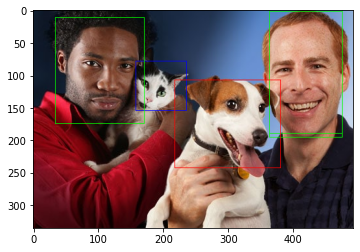

In [ ]:
import colorsys
import random

num_classes = 3
image_h, image_w, _ = original_image.shape
hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

random.seed(0)
random.shuffle(colors)
random.seed(None)

for i in range(len(boxes)):
  coor = boxes[i][:]
  coor[0] = int(coor[0] * image_h)
  coor[2] = int(coor[2] * image_h)
  coor[1] = int(coor[1] * image_w)
  coor[3] = int(coor[3] * image_w)

  fontScale = 0.5
  score = pred_conf[i][:]
  class_ind = np.where(score==score.max())[0][0]
  bbox_color = colors[class_ind]
  bbox_thick = int(0.6 * (image_h + image_w) / 300)
  c1, c2 = (coor[1].astype(int), coor[0].astype(int)), (coor[3].astype(int), coor[2].astype(int))

  cv2.rectangle(original_image, c1, c2, bbox_color, bbox_thick)

import matplotlib.pyplot as plt
plt.imshow(original_image)

# **(5) Pytorch -> Keras -> TensorFlow**

In [ ]:
# download source code
%cd /content
!git clone https://github.com/david8862/keras-YOLOv3-model-set

# install package
%cd keras-YOLOv3-model-set/
!apt install python3-opencv
!pip install Cython
!pip install -r requirements.txt

# link
!ln -fs /content/drive/MyDrive/Colab_Model_ZOO/YOLOv4_TINY_Training/darknet /app

In [ ]:
!wget -O weights/yolov4.weights https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

In [ ]:
%cd /content/keras-YOLOv3-model-set
model_weight = "/app/backup_relu/my_yolov4-tiny-custom_final.weights" #@param["/app/backup_relu/yolov4-tiny_10000.weights","/app/backup_relu/my_yolov4-tiny-custom_final.weights"]
model_cfg = "cfg/yolov4-tiny.cfg" #@param["cfg/yolov4.cfg","cfg/yolov4-tiny.cfg","cfg/yolov3.cfg","cfg/yolov3-tiny.cfg"]
output_keras_model = "weights/yolov4-tiny.h5"
!python tools/model_converter/convert.py {model_cfg} {model_weight} {output_keras_model}

In [ ]:
!python tools/model_converter/keras_to_tensorflow.py --input_model="./weights/yolov4.h5" --output_model="./weights/yolov4.pb"

In [ ]:
# Tensorflow 2.7
import tensorflow as tf
import numpy as np
def representative_dataset_gen(): # 模擬數據集 (已亂隨構成的測試集會影像精準度)
    for _ in range(250):
        yield [np.random.uniform(0.0, 1.0, size=(1, 416, 416, 3)).astype(np.float32)] # H,W,C 為模組所須輸入的影像大小

#converter = tf.lite.TFLiteConverter.from_keras_model("weights/yolov4-tiny.h5")
converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file(r"/content/keras-YOLOv3-model-set/weights/yolov4-tiny.h5")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.SELECT_TF_OPS]
converter.inference_input_type  = tf.uint8
converter.inference_output_type = tf.uint8
converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()
with tf.io.gfile.GFile( "/content/yolov4-quant.tflite" , 'wb') as f:
   f.write(tflite_model)
print("Quantization complete! - model.tflite ")